In [580]:
using wgregseq, CairoMakie, DataFrames, Statistics, StatsBase, LinearAlgebra, BioSequences, Printf, CSV

wgregseq.plotting_style.default_makie!()

In [581]:
data = [
    3, 1, "ACGGACGTAC",
    5, 1, "ACGTACGTAC",
    5, 3, "TCGTACGTAC",
    8, 4, "TCGTACGTAC",
    8, 6, "AAGTACGTAC",
    6, 5, "AAGTACGTAC",
    1, 1, "ACATACGTAC",
    5, 3, "ACATACGTAC",
    3, 1, "ACGAACGTAC",
    6, 2, "ACGGCCGTAC",
    3, 1, "ACGGATGTAC",
    10, 1, "ACGTACGTAT",
    15, 2, "ACGTACGTAT",
    6, 1, "ACGTACGTCC",
    12, 3, "ACGTACGTCC",
    15, 1, "ACGTACGGAC",
    10, 1, "ACGTACGGAC",
    20, 3, "ACGTACTTAC",
    4, 1, "ACGTACTTAC",

 
]
    


dna_counts = Int.(data[1:3:end])
rna_counts = Int.(data[2:3:end])
sequences =  String.(data[3:3:end])
df = DataFrame(DNA_counts=dna_counts, RNA_counts=rna_counts, sequence=sequences)

,DNA_counts,RNA_counts,sequence
,Int64,Int64,String
1,3,1,ACGGACGTAC
2,5,1,ACGTACGTAC
3,5,3,TCGTACGTAC
4,8,4,TCGTACGTAC
5,8,6,AAGTACGTAC
6,6,5,AAGTACGTAC
7,1,1,ACATACGTAC
8,5,3,ACATACGTAC
9,3,1,ACGAACGTAC


In [582]:
mean(rna_counts ./ dna_counts)

0.3701754385964912

## Expression shift.

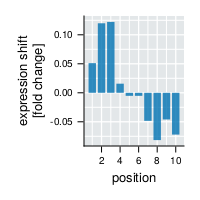

In [602]:
df = DataFrame(DNA_counts=dna_counts, RNA_counts=rna_counts, sequence=sequences)
insertcols!(df, 1, :relative_counts => df.RNA_counts ./ df.DNA_counts)
insertcols!(df, 1, :total_counts => df.RNA_counts ./ df.DNA_counts)

# transform sequences to integers
DNA_dict = Dict('A'=>1, 'C'=>2, 'G'=>3, 'T'=>4)
function make_int(x)
    return [DNA_dict[y] for y in x]
end

int_promoter = make_int.(df.sequence)
freq_mat = zeros(2, 4, 10)

for (gDNA_counts, cDNA_counts, prom) in zip(df.DNA_counts, df.RNA_counts, int_promoter)
    for j in 1:10
        freq_mat[1, prom[j], j] += gDNA_counts
        freq_mat[2, prom[j], j] += cDNA_counts
    end
end

freq_mat = freq_mat ./ sum(freq_mat, dims=2)
wt_seq = make_int(df.sequence[1])

is_mut(x) = (x .!= wt_seq)
is_wt(x) = (x .== wt_seq)
is_mutated = is_mut.(int_promoter)

mean_rel_counts = mean(df.relative_counts)
tot_counts = sum(df.total_counts)

ex_shift_arr = zeros(10)
for (x, seq, c) in zip(df.relative_counts, is_mutated, df.total_counts)
    ex_shift_arr[seq] .+= (x - mean_rel_counts)/mean_rel_counts
end

ex_shift_arr = ex_shift_arr ./ length(sequences)

fig = Figure(resolution=(200, 200))
ax = Axis(fig[1, 1])
barplot!(ax, ex_shift_arr)
ax.ylabel = "expression shift\n[fold change]"
ax.xlabel = "position"
save("../../doc/figures/example_expression_shift.pdf", fig)

fig

In [584]:
df_rspA = CSV.read("../../data/regseq_elife/rspALBdataset_alldone_with_large", DataFrame, ignorerepeated=true, delim=" ")
df_rspA.seq = map(x -> x[1:160], df_rspA.seq)
df_rspA = df_rspA[df_rspA.ct_0 .> 0, :]
insertcols!(df_rspA, 1, :relative_counts => df_rspA.ct_1 ./ df_rspA.ct_0)

# transform sequences to integers
DNA_dict = Dict('A'=>1, 'C'=>2, 'G'=>3, 'T'=>4)
function make_int(x)
    return [DNA_dict[y] for y in x]
end

int_promoter = make_int.(df_rspA.seq)
freq_mat = zeros(2, 4, 160)

for (gDNA_counts, cDNA_counts, prom) in zip(df_rspA.ct_0, df_rspA.ct_1, int_promoter)
    for j in 1:160
        freq_mat[1, prom[j], j] += gDNA_counts
        freq_mat[2, prom[j], j] += cDNA_counts
    end
end

freq_mat = freq_mat ./ sum(freq_mat, dims=2);


In [585]:
wt_seq = [x[1] for x in argmax(freq_mat[1, :, :], dims=1)] |> vec

is_mut(x) = (x .!= wt_seq)
is_wt(x) = (x .== wt_seq)
is_mutated = is_mut.(int_promoter)

mean_rel_counts = mean(df_rspA.relative_counts)

ex_shift_arr = zeros(160)
for (x, seq) in zip(df_rspA.relative_counts, is_mutated)
    ex_shift_arr[seq] .+= (x - mean_rel_counts)/mean_rel_counts
end

ex_shift_arr = ex_shift_arr ./ nrow(df_rspA);

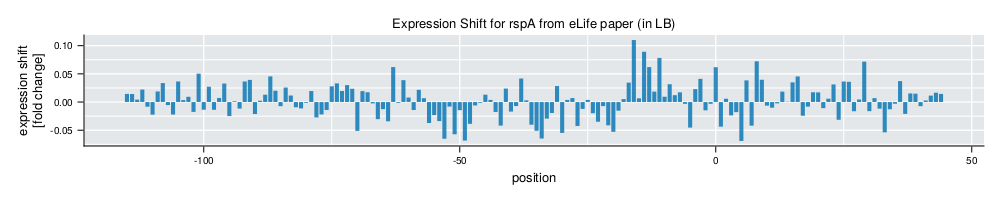

In [586]:
fig = Figure(resolution=(1000, 200))
ax = Axis(fig[1, 1])
barplot!(ax, -115:44, ex_shift_arr)
ax.ylabel = "expression shift\n[fold change]"
ax.xlabel = "position"
ax.title = "Expression Shift for rspA from eLife paper (in LB)"

fig

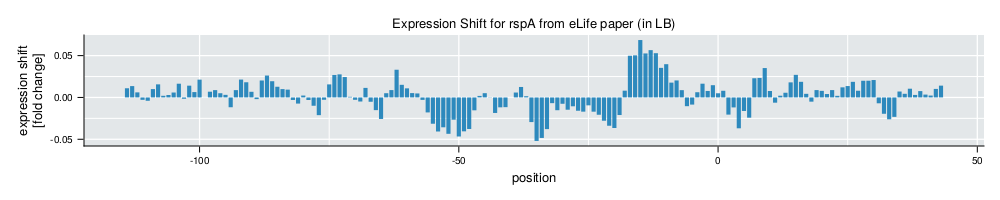

In [587]:
fig = Figure(resolution=(1000, 200))
ax = Axis(fig[1, 1])
d=1
barplot!(ax, -115+d:44-d, [mean(ex_shift_arr[i-d:i+d]) for i in d+1:160-d])
ax.ylabel = "expression shift\n[fold change]"
ax.xlabel = "position"
ax.title = "Expression Shift for rspA from eLife paper (in LB)"
save("../../doc/figures/exp_shift_rspA_elife.pdf", fig)
fig

## Mutual information (data)

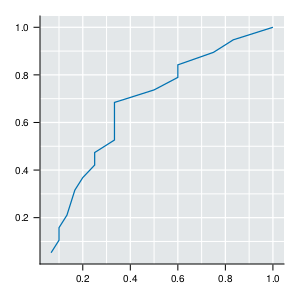

In [588]:
fig = Figure(resolution=(300, 300))
ax = Axis(fig[1, 1])
lines!(ax, sort(df.relative_counts), 1/nrow(df):1/nrow(df):1)
fig

In [589]:
fit(Histogram, df.relative_counts, nbins=8)

Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  0.0:0.2:1.2000000000000002
weights: [6, 7, 3, 1, 1, 1]
closed: left
isdensity: false

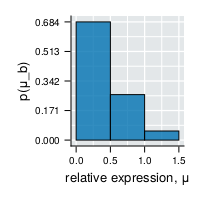

In [590]:
fig = Figure(resolution=(200, 200))
ax = Axis(fig[1, 1])
f = fit(Histogram, df.relative_counts, nbins=4)
norm_weights = f.weights ./ nrow(df)
ax.xlabel = "relative expression, μ"
ax.ylabel = "p(μ_b)"
ax.yticks = (range(0, maximum(f.weights), length=5),[Printf.format(Printf.Format("%0.3f"), f) for f in  range(0, maximum(norm_weights), length=5)])

barplot!(ax, f, width=0.8, strokewidth=1)

fig

In [591]:
bins = f.edges[1] |> collect
nbins = length(bins) - 1

df = DataFrame(DNA_counts=dna_counts, RNA_counts=rna_counts, sequence=sequences)
insertcols!(df, 1, :relative_counts => df.RNA_counts ./ df.DNA_counts)
insertcols!(df, 1, :total_counts => df.RNA_counts ./ df.DNA_counts)
insertcols!(df, 1, :bin => map(x -> findfirst(y-> x < y, bins) - 1, df.relative_counts));
nbins

3

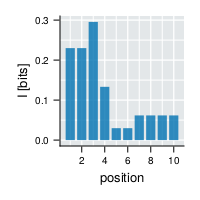

In [592]:
# bins, bases
p = zeros(10, nbins, 4)



# bins
for j in 1:10
    counts = countmap([[df.bin[i], df.sequence[i][j]] for i in 1:nrow(df)])
    for key in keys(counts) |> collect
        p[j, key[1], DNA_dict[key[2]]] = counts[key]
    end
end

p = p./nrow(df)

function clog(x, y, z)
    if x == 0 || y == 0 || z==0
        return 0
    else
        return x * log2(x / (y* z))
    end
end

mut_information = [sum([clog(p[i, j, k], sum(p[i, :, k]), sum(p[i, j, :])) for j in 1:nbins for k in 1:4]) for i in 1:10]

p[1, :, :] |> sum

function clog(x, y, z)
    if x == 0 || y == 0 || z==0
        return 0
    else
        return x * log2(x / (y* z))
    end
end

mut_information = [sum([clog(p[i, j, k], sum(p[i, :, k]), sum(p[i, j, :])) for j in 1:nbins for k in 1:4]) for i in 1:10]

fig = Figure(resolution=(200, 200))
ax = Axis(fig[1, 1])
barplot!(ax, mut_information)
ax.ylabel = "I [bits]"
ax.xlabel = "position"
save("../../doc/figures/example_MI_bases_bins.pdf", fig)
fig


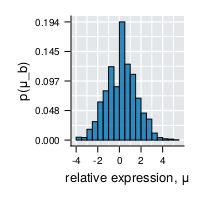

In [593]:
_df_rspA = df_rspA[df_rspA.ct_1 .> 0, :]
fig = Figure(resolution=(200, 200))
ax = Axis(fig[1, 1])
f = fit(Histogram, log.(_df_rspA.relative_counts), nbins=20)
norm_weights = f.weights ./ nrow(_df_rspA)
ax.xlabel = "relative expression, μ"
ax.ylabel = "p(μ_b)"
ax.yticks = (range(0, maximum(f.weights), length=5),[Printf.format(Printf.Format("%0.3f"), f) for f in  range(0, maximum(norm_weights), length=5)])
save("../../figures/MI_bases_bins_rpsA_elife.pdf", fig)
barplot!(ax, f, width=0.8, strokewidth=1)

fig

In [594]:
bins = f.edges[1] |> collect
nbins = length(bins) - 1

df_rspA = CSV.read("../../data/regseq_elife/rspALBdataset_alldone_with_large", DataFrame, ignorerepeated=true, delim=" ")
df_rspA.seq = map(x -> x[1:160], df_rspA.seq)
df_rspA = df_rspA[df_rspA.ct_0 .> 0, :]
_df_rspA = df_rspA[df_rspA.ct_1 .> 0, :]
insertcols!(_df_rspA, 1, :relative_counts => _df_rspA.ct_1 ./ _df_rspA.ct_0)
insertcols!(_df_rspA, 1, :bin => map(x -> findfirst(y-> log(x) < y, bins) - 1, _df_rspA.relative_counts))

,bin,relative_counts,ct,ct_0,ct_1,seq
,Int64,Float64,Float64,Float64,Float64,String
1,6,0.25,5.0,4.0,1.0,AACAAAAGGTACTCTCTTTCATCTTTTATCAACCGTTCACTGCGCAAATATACGCCTTTTTTTTTGATTACTCCTGTTTATTTCGATCTTTATCCTTGTTTAGTAGCTGCTCAGTCACGTAGCTTTCATGCATGACGACAAGCTATGCAAGGTATGGAAC
2,6,0.25,5.0,4.0,1.0,AACAAAAGGTATTCTAATTGATCTTTTGTCAAACCTTCACAGCGCAAATTTACGCCCTTGTTTGTGATCACTACGACTTTTGTCGATCTTTATACTTGTATGGTGGTAGCTCAGTTGCGTAGATTTCATGCATCACCGCAGGCGATGCAAGGAATCGAGC
3,6,0.25,5.0,4.0,1.0,AACAAAAGGTATTCTACTTCATCTTTTGACAAACCTCCACAGCCCAAATATACGCCTTTTTTTGTGATCAGTCCGGCTTTATTCGATCTTTAAACTTATATGGTAGTAGGTTAGTTGCGTAGAGATCATGTATCCCGACAAGAGATGCAAGGATTCGAAC
4,11,4.0,20.0,4.0,16.0,AACAAAAGGTATTCTAGTGCATCTTTTGACAACCGTTCTCAGCGCAGATATACGCCTTTTTTTGTGAGCACTGCGGCTTTTTTCGATCTTTATACTTCTATGGTAGTAGCTCAGTAGCGGAGATTTCATGCATCACGACAAGCGATGCAAGGAATCGCAC
5,15,27.0,28.0,1.0,27.0,AACAAAAGGTATTCTATTTCATCTTTTGCAAACCTGTCACAACCCAAAATGACGCCTTATTTTGTGGTCACTCCGCCTCTTTTCGTTCTTTATACGTGTATGGAAGTAGGTCAGTTGCGTAGATGTCATGCATCACGACAAGCGACGCCACGAATCGAAC
6,13,7.5,17.0,2.0,15.0,AACAAAAGGTATTCTATTTCATCTTTTGCAAACCTGTCACAACCCAAAATGACGCCTTATTTTGTGGTCACTCCGCCTCTTTTCGTTCTTTATACGTGTATGGAAGTAGGTCAGTTGCGTAGATGTCATGCATCACGACAAGCGACGCCACGAATCGAAC
7,11,4.0,5.0,1.0,4.0,AACAAAAGGTATTCTATTTCATCTTTTGTCAACCATTCATATCGCAAATATACGCCTTTTTTTGTGATCATTACGGCTTTTTTCGATCTCTATACTTGTATGGTAGTAGCTAAGTTACGTAGAATTCCTGCATCACGACATGCGATGCAAGGAATCGAAC
8,10,2.66667,11.0,3.0,8.0,AACAAAAGGTATTCTATTTCATCTTTTGTCCACCATTCACAGCGCAATTATACGCCTTTTTTTGTGATCACCCCGGCTTTTTGCGATCTTTATACTCGTACGGTAGTAGCTCAGTTGCGTAGAATTCATGGATCGCGACAAGCGATGCAAGGAATCGAAC
9,12,6.33333,22.0,3.0,19.0,AACAAAAGGTATTCTATTTCATCTTTTGTCCACCATTCACAGCGCAATTATACGCCTTTTTTTGTGATCACCCCGGCTTTTTGCGATCTTTATACTCGTACGGTAGTAGCTCAGTTGCGTAGAATTCATGGATCGCGACAAGCGATGCAAGGAATCGAAC


In [595]:
# bins, bases
p = zeros(160, nbins, 4)

# bins
for j in 1:160
    counts = countmap([[_df_rspA.bin[i], _df_rspA.seq[i][j]] for i in 1:nrow(df)])
    for key in keys(counts) |> collect
        p[j, key[1], DNA_dict[key[2]]] = counts[key]
    end
end

p = p./nrow(df)

function clog(x, y, z)
    if x == 0 || y == 0 || z==0
        return 0
    else
        return x * log2(x / (y* z))
    end
end

mut_information = [sum([clog(p[i, j, k], sum(p[i, :, k]), sum(p[i, j, :])) for j in 1:nbins for k in 1:4]) for i in 1:10]

p[1, :, :] |> sum

function clog(x, y, z)
    if x == 0 || y == 0 || z==0
        return 0
    else
        return x * log2(x / (y* z))
    end
end

mut_information = [sum([clog(p[i, j, k], sum(p[i, :, k]), sum(p[i, j, :])) for j in 1:nbins for k in 1:4]) for i in 1:160]


160-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.126676854296314
 0.3146653661229381
 0.3146653661229381
 0.0
 ⋮
 0.0
 0.126676854296314
 0.28765843461008406
 0.0
 0.126676854296314
 0.419928524017675
 0.49818475039955773
 0.126676854296314
 0.126676854296314

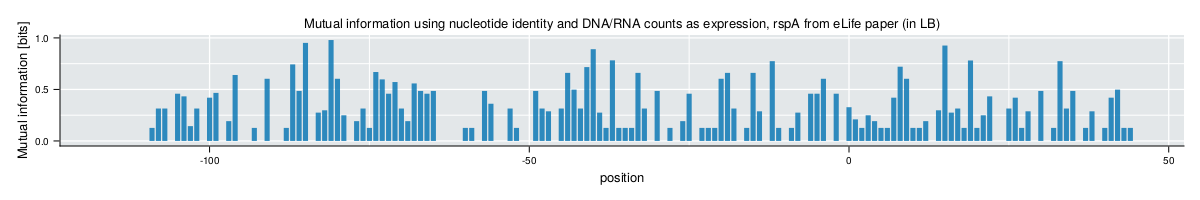

In [596]:
fig = Figure(resolution=(1200, 200))
ax = Axis(fig[1, 1])
barplot!(ax, -115:44, mut_information)
ax.ylabel = "Mutual information [bits]"
ax.xlabel = "position"
ax.title = "Mutual information using nucleotide identity and DNA/RNA counts as expression, rspA from eLife paper (in LB)"

fig

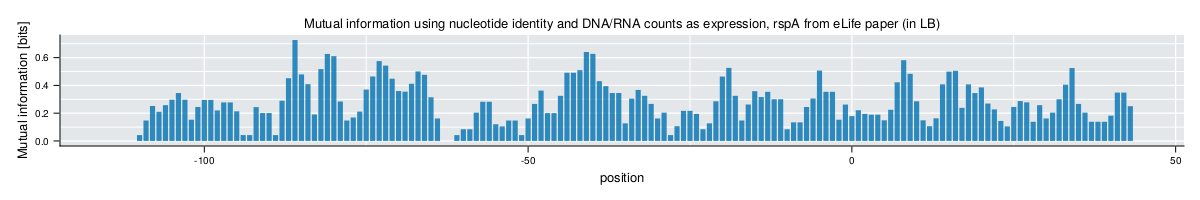

In [597]:
fig = Figure(resolution=(1200, 200))
ax = Axis(fig[1, 1])
d=1
barplot!(ax, -115+d:44-d, [mean(mut_information[i-d:i+d]) for i in d+1:160-d])
ax.ylabel = "Mutual information [bits]"
ax.xlabel = "position"
ax.title = "Mutual information using nucleotide identity and DNA/RNA counts as expression, rspA from eLife paper (in LB)"
save("../../doc/figures/MI_bases_bins_rpsA_elife.pdf", fig)
fig

## Frequency Matrices

In [598]:
df = DataFrame(DNA_counts=dna_counts, RNA_counts=rna_counts, sequence=sequences)
insertcols!(df, 1, :relative_counts => df.RNA_counts ./ df.DNA_counts)
insertcols!(df, 1, :total_counts => df.RNA_counts ./ df.DNA_counts)


# transform sequences to integers
DNA_dict = Dict('A'=>1, 'C'=>2, 'G'=>3, 'T'=>4)
function make_int(x)
    return [DNA_dict[y] for y in x]
end

int_promoter = make_int.(sequences)
freq_mat = zeros(2, 4, 10)

for (gDNA_counts, cDNA_counts, prom) in zip(dna_counts, rna_counts, int_promoter)
    for j in 1:10
        freq_mat[1, prom[j], j] += gDNA_counts
        freq_mat[2, prom[j], j] += cDNA_counts
    end
end

freq_mat = freq_mat ./ sum(freq_mat, dims=2)
wt_seq = make_int(sequences[1])

freq_diffs = (freq_mat[1, :, :] - freq_mat[2, :, :])

4×10 Matrix{Float64}:
  0.0810765  -0.171741  -0.0561817  …   0.0       -0.026577   0.0
  0.0         0.171741   0.0            0.0        0.026577  -0.0992431
  0.0         0.0        0.0561817      0.123633   0.0        0.0
 -0.0810765   0.0        0.0           -0.123633   0.0        0.0992431

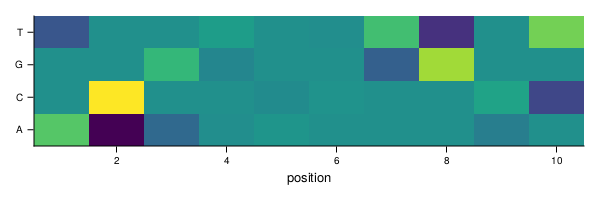

In [599]:
fig = Figure(resolution=(600, 200))
ax = Axis(fig[1, 1], yticks=([1, 2, 3, 4], ["A", "C", "G", "T"]))
heatmap!(ax, freq_diffs')
#ax.ylabel = "expression shift\n[fold change]"
ax.xlabel = "position"

fig

In [600]:
mean(abs.(freq_diffs), dims=1)|>vec

10-element Vector{Float64}:
 0.04053826745164006
 0.08587047939444914
 0.028090832632464258
 0.009251471825063083
 0.0037005887300252498
 0.001850294365012611
 0.03397813288477713
 0.06181665264928511
 0.013288477712363342
 0.049621530698065616

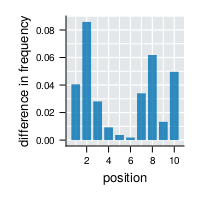

In [601]:
fig = Figure(resolution=(200, 200))
ax = Axis(fig[1, 1])
barplot!(ax, mean(abs.(freq_diffs), dims=1)|>vec)
ax.ylabel = "difference in frequency"
ax.xlabel = "position"
save("../../doc/figures/example_freq_mat.pdf", fig)
fig

In [609]:
df_rspA = CSV.read("../../data/regseq_elife/rspALBdataset_alldone_with_large", DataFrame, ignorerepeated=true, delim=" ")
df_rspA.seq = map(x -> x[1:160], df_rspA.seq)
df_rspA = df_rspA[df_rspA.ct_0 .> 0, :]
_df_rspA = df_rspA[df_rspA.ct_1 .> 0, :]
insertcols!(_df_rspA, 1, :relative_counts => _df_rspA.ct_1 ./ _df_rspA.ct_0)


# transform sequences to integers
DNA_dict = Dict('A'=>1, 'C'=>2, 'G'=>3, 'T'=>4)
function make_int(x)
    return [DNA_dict[y] for y in x]
end

int_promoter = make_int.(df_rspA.seq)
freq_mat = zeros(2, 4, 160)

for (gDNA_counts, cDNA_counts, prom) in zip( _df_rspA.ct_0, _df_rspA.ct_1, int_promoter)
    for j in 1:160
        freq_mat[1, prom[j], j] += gDNA_counts
        freq_mat[2, prom[j], j] += cDNA_counts
    end
end

freq_mat = freq_mat ./ sum(freq_mat, dims=2)
wt_seq = make_int(df_rspA.seq[1])

freq_diffs = (freq_mat[1, :, :] - freq_mat[2, :, :])

4×160 Matrix{Float64}:
 -0.000884584  -0.00818677  -0.018051     …  -0.00914541    0.00157919
  0.0245336     0.00139784   0.00948557      -0.00224065    0.000628886
 -0.0236491     0.00385189   0.00887452       0.000992681  -0.000168942
  0.0           0.00293704  -0.000309133      0.0103934    -0.00203914

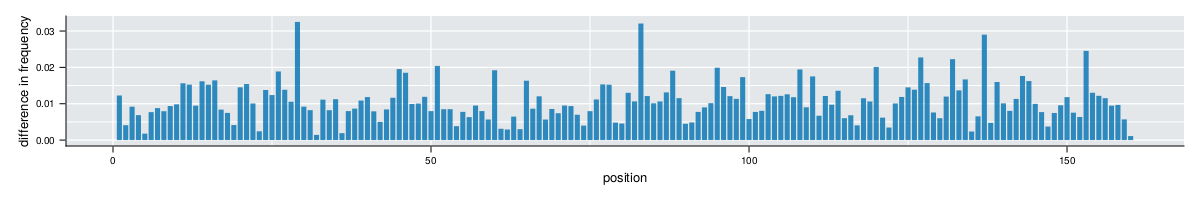

In [611]:
fig = Figure(resolution=(1200, 200))
ax = Axis(fig[1, 1])
barplot!(ax, mean(abs.(freq_diffs), dims=1)|>vec)
ax.ylabel = "difference in frequency"
ax.xlabel = "position"
save("../../doc/figures/freq_mat_rspA_elife.pdf", fig)
fig